In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# filename = "/content/drive/MyDrive/Colab Notebooks/大数据基础/data.xlsx"
filename = 'data.xlsx'
df = pd.read_excel(filename,header=0,sheet_name='因子分析2',index_col='编号')
df.head(5)
# index如果有重复值，需要重新index一下，不然后面可能会出错
df.index = range(df.shape[0])
df.head()

,有机含量,黏土矿物,FeS2,碳酸盐,SiO2,Fe2O3,Al2O3,CaO,MgO
0,86.76,12.25,0.00,0.40,46.20,5.26,34.55,3.58,1.30
1,92.52,7.32,0.00,0.16,47.52,3.68,37.70,1.95,0.59
2,96.79,3.07,0.17,0.00,47.86,7.82,36.77,1.38,0.63
3,85.56,13.03,0.94,0.47,45.04,7.44,36.06,3.43,0.65
4,87.75,10.26,1.23,0.76,36.22,24.29,29.25,3.23,1.15


In [34]:
## 设置显示中文（Colab）
# import matplotlib as mpl
# zhfont = mpl.font_manager.FontProperties(fname='/content/drive/MyDrive/Colab Notebooks/大数据基础/SimHei.ttf')
# plt.rcParams['axes.unicode_minus'] = False
# # ,fontproperties=zhfont
# ## for Seaborn
# sns.set(font=zhfont.get_name())

In [35]:
# 设置显示中文（正常情况下）
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
sns.set(font='SimHei')

# KMeans

In [53]:
from sklearn.cluster import KMeans
from sklearn import metrics
# x = np.array([[1,2],[1,4],[1,0],[10,2],[10,4],[10,0]])
X=df.iloc[:,0:2]
print(X)
Kmeans = KMeans(n_clusters=2,random_state=0).fit(X)
Kmeans.labels_

     有机含量   黏土矿物
0   86.76  12.25
1   92.52   7.32
2   96.79   3.07
3   85.56  13.03
4   87.75  10.26
5   75.69  24.06
6   99.21   0.63
7   84.50  14.46
8   94.14   5.86
9   90.50   6.72
10  72.05  26.49
11  98.10   1.71
12  96.35   3.13
13  98.48   0.00
14  88.51   2.54
15  79.75  19.63
16  94.54   0.76
17  91.51   7.88
18  90.89   3.04
19  69.79  24.13
20  78.47  20.60
21  60.71  29.28
22  73.03  24.09
23  86.35   4.99


array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0])

In [54]:
Kmeans.cluster_centers_

array([[91.90941176,  5.74411765],
       [72.78428571, 24.04      ]])

In [59]:
Kmeans.predict([[86,12],[45,3.1],[100,2]])

d:\big_data_test\envi\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


array([0, 1, 0])

## 最佳k值的确定
### 拐点法

就是在不同的k值下计算簇内离差平方和，然后通过可视化的方法找到“拐点”所对应的k值。正如前文所介绍的Kmeans聚类算法的目标函数J，随着簇数量的增加，簇中的样本量会越来越少，进而导致目标函数J的值也会越来越小。通过可视化方法，重点关注的是斜率的变化，当斜率由大突然变小时，并且之后的斜率变化缓慢，则认为突然变化的点就是寻找的目标点，因为继续随着簇数k的增加，聚类效果不再有大的变化。
为了验证这个方法的直观性，这里随机生成三组二元正态分布数据，首先基于该数据绘制散点图


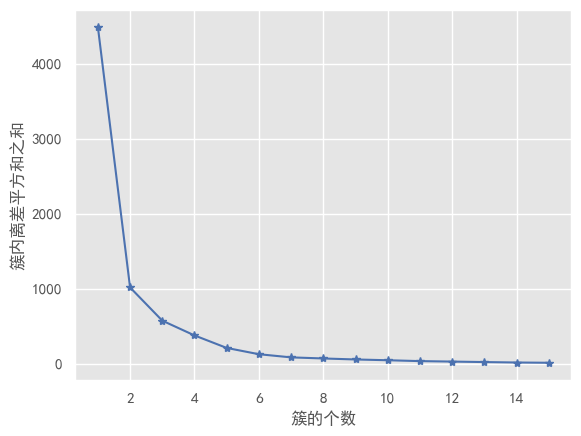

In [56]:
# 构造自定义函数，用于绘制不同k值和对应总的簇内离差平方和的折线图
def k_SSE(X, clusters):
    # 选择连续的K种不同的值
    K = range(1,clusters+1)
    # 构建空列表用于存储总的簇内离差平方和
    TSSE = []
    for k in K:
        # 用于存储各个簇内离差平方和
        SSE = []
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        # 返回簇标签
        labels = kmeans.labels_
        # 返回簇中心
        centers = kmeans.cluster_centers_
        # 计算各簇样本的离差平方和，并保存到列表中
        for label in set(labels):
            SSE.append(np.sum((X.loc[labels == label,]-centers[label,:])**2))
        # 计算总的簇内离差平方和 
        TSSE.append(np.sum(SSE))

    # 中文和负号的正常显示
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
    plt.rcParams['axes.unicode_minus'] = False
    # 设置绘图风格
    plt.style.use('ggplot')
    # 绘制K的个数与GSSE的关系
    plt.plot(K, TSSE, 'b*-')
    plt.xlabel('簇的个数')
    plt.ylabel('簇内离差平方和之和')
    # 显示图形
    plt.show()

# 将三组数据集汇总到数据框中

# 自定义函数的调用
k_SSE(X, 15)


### 轮廓系数法

有关轮廓系数的计算，可以直接调用sklearn子模块metrics中的函数，即
silhouette_score。需要注意的是，该函数接受的聚类簇数必须大于等于2。下面基于该函数重新自定义一个函数，用于绘制不同k值下对应轮廓系数的折线图

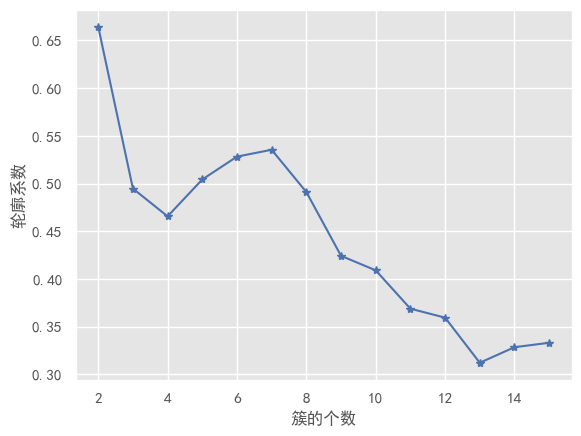

In [57]:
# 构造自定义函数，用于绘制不同k值和对应轮廓系数的折线图
def k_silhouette(X, clusters):
    K = range(2,clusters+1)
    # 构建空列表，用于存储个中簇数下的轮廓系数
    S = []
    for k in K:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        labels = kmeans.labels_
        # 调用字模块metrics中的silhouette_score函数，计算轮廓系数
        S.append(metrics.silhouette_score(X, labels, metric='euclidean'))

    # 中文和负号的正常显示
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
    plt.rcParams['axes.unicode_minus'] = False
    # 设置绘图风格
    plt.style.use('ggplot')    
    # 绘制K的个数与轮廓系数的关系
    plt.plot(K, S, 'b*-')
    plt.xlabel('簇的个数')
    plt.ylabel('轮廓系数')
    # 显示图形
    plt.show()
    
# 自定义函数的调用
k_silhouette(X, 15)


当k等于2时，轮廓系数最大，且比较接近于1，说明应该把数据聚为2类比较合理

### 间隔统计量法

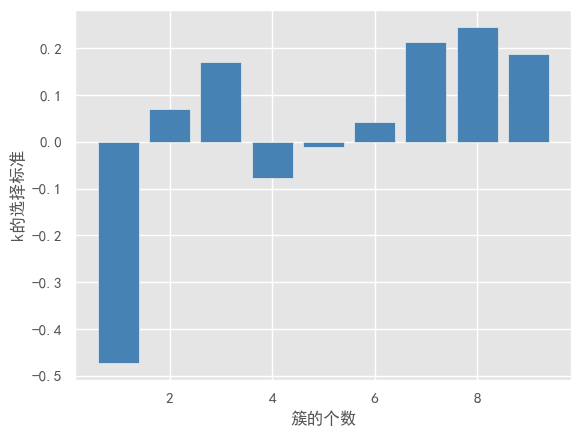

In [58]:
# 自定义函数，计算簇内任意两样本之间的欧氏距离
def short_pair_wise_D(each_cluster):
    mu = each_cluster.mean(axis = 0)
    Dk = sum(sum((each_cluster - mu)**2)) * 2.0 * each_cluster.shape[0]
    return Dk

# 计算簇内的Wk值
def compute_Wk(data, classfication_result):
    Wk = 0
    label_set = set(classfication_result)
    for label in label_set:
        each_cluster = data[classfication_result == label, :]
        Wk = Wk + short_pair_wise_D(each_cluster)/(2.0*each_cluster.shape[0])
    return Wk

# 计算GAP统计量 
def gap_statistic(X, B=10, K=range(1,11), N_init = 10):
    # 将输入数据集转换为数组
    X = np.array(X)
    # 生成B组参照数据
    shape = X.shape
    tops = X.max(axis=0)
    bots = X.min(axis=0)
    dists = np.matrix(np.diag(tops-bots))
    rands = np.random.random_sample(size=(B,shape[0],shape[1]))
    for i in range(B):
        rands[i,:,:] = rands[i,:,:]*dists+bots
    
    # 自定义0元素的数组，用于存储gaps、Wks和Wkbs
    gaps = np.zeros(len(K))
    Wks = np.zeros(len(K))
    Wkbs = np.zeros((len(K),B))
    # 循环不同的k值，
    for idxk, k in enumerate(K):
        k_means =  KMeans(n_clusters=k)
        k_means.fit(X)
        classfication_result = k_means.labels_
        # 将所有簇内的Wk存储起来
        Wks[idxk] = compute_Wk(X,classfication_result)
        
        # 通过循环，计算每一个参照数据集下的各簇Wk值
        for i in range(B):
            Xb = rands[i,:,:]
            k_means.fit(Xb)
            classfication_result_b = k_means.labels_
            Wkbs[idxk,i] = compute_Wk(Xb,classfication_result_b)

    # 计算gaps、sd_ks、sk和gapDiff
    gaps = (np.log(Wkbs)).mean(axis = 1) - np.log(Wks)        
    sd_ks = np.std(np.log(Wkbs), axis=1)
    sk = sd_ks*np.sqrt(1+1.0/B)
    # 用于判别最佳k的标准，当gapDiff首次为正时，对应的k即为目标值
    gapDiff = gaps[:-1] - gaps[1:] + sk[1:]
    
    # 中文和负号的正常显示
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
    plt.rcParams['axes.unicode_minus'] = False
    # 设置绘图风格
    plt.style.use('ggplot')
    # 绘制gapDiff的条形图
    plt.bar(np.arange(len(gapDiff))+1, gapDiff, color = 'steelblue')
    plt.xlabel('簇的个数')
    plt.ylabel('k的选择标准')
    plt.show()
    
# 自定义函数的调用
gap_statistic(X)    


x轴代表了不同的簇数k，y轴代表k值选择的判断指标gapDiff，gapDiff首次
出现正值时对应的k为2。所以，对于数据集来说，将其划分为2个簇是比较合理的，同样与预设的簇数一致。代码中自定义了3个函数，分别用于计算公式中的Dk、Wk和Gapk，虽然计算逻辑比较简单，但是涉及的循环比较多，所以对大数据集而言，其k值的确定会比较慢。


In [63]:
# 构建Kmeans模型
Y = df
kmeans = KMeans(n_clusters = 3)
kmeans.fit(Y)
# 聚类结果标签
Y['cluster'] = kmeans.labels_
print(Y['cluster'])
# 各类频数统计
Y.cluster.value_counts()

0     2
1     2
2     2
3     2
4     1
5     0
6     2
7     2
8     2
9     2
10    0
11    2
12    1
13    1
14    1
15    0
16    1
17    2
18    2
19    0
20    0
21    0
22    0
23    1
Name: cluster, dtype: int32


2    11
0     7
1     6
Name: cluster, dtype: int64

d:\big_data_test\envi\lib\site-packages\seaborn\regression.py:582: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


[[88.21777778  8.82777778]
 [72.78428571 24.04      ]
 [96.0625      2.275     ]]


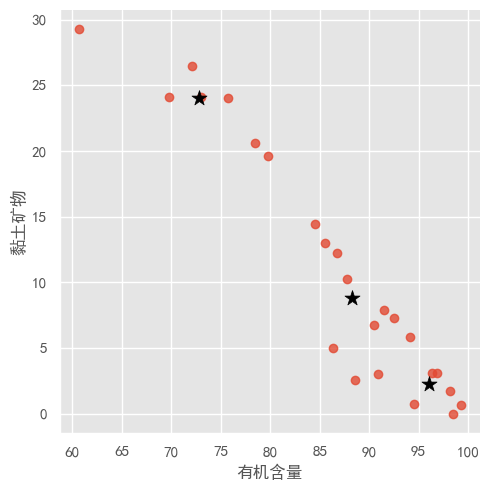

In [11]:
# 导入第三方模块
import seaborn as sns

# 三个簇的簇中心
centers = kmeans.cluster_centers_
print(centers)
# 绘制聚类效果的散点图
sns.lmplot(x = '有机含量', y = '黏土矿物', data = X, fit_reg = False, scatter_kws = {'alpha':0.8}, legend_out = False)
plt.scatter(centers[:,0], centers[:,1], marker = '*', color = 'black', s = 130)
plt.xlabel('有机含量')
plt.ylabel('黏土矿物')
# 图形显示
plt.show()


# 聚类层次树-dendrogram

In [75]:
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
import scipy.cluster as sc
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist


#### 对变量进行聚类

In [76]:
df_list = df.values
X =np.matrix(df_list)
print(X)
X_std = (X - np.mean(X,axis=0))/st.tstd(X,axis=0)#注意这里要使用标准差的无偏估计
names = df.index.tolist()
print(names)

[[8.676e+01 1.225e+01 0.000e+00 4.000e-01 4.620e+01 5.260e+00 3.455e+01
  3.580e+00 1.300e+00 2.000e+00]
 [9.252e+01 7.320e+00 0.000e+00 1.600e-01 4.752e+01 3.680e+00 3.770e+01
  1.950e+00 5.900e-01 2.000e+00]
 [9.679e+01 3.070e+00 1.700e-01 0.000e+00 4.786e+01 7.820e+00 3.677e+01
  1.380e+00 6.300e-01 2.000e+00]
 [8.556e+01 1.303e+01 9.400e-01 4.700e-01 4.504e+01 7.440e+00 3.606e+01
  3.430e+00 6.500e-01 2.000e+00]
 [8.775e+01 1.026e+01 1.230e+00 7.600e-01 3.622e+01 2.429e+01 2.925e+01
  3.230e+00 1.150e+00 1.000e+00]
 [7.569e+01 2.406e+01 0.000e+00 2.500e+00 4.740e+01 3.760e+00 4.000e+01
  9.700e-01 1.150e+00 0.000e+00]
 [9.921e+01 6.300e-01 1.600e-01 0.000e+00 8.662e+01 8.870e+00 3.175e+01
  2.820e+00 9.600e-01 2.000e+00]
 [8.450e+01 1.446e+01 1.040e+00 0.000e+00 4.694e+01 1.459e+01 3.735e+01
  2.200e+00 8.900e-01 2.000e+00]
 [9.414e+01 5.860e+00 0.000e+00 0.000e+00 4.866e+01 8.410e+00 3.842e+01
  5.100e-01 6.700e-01 2.000e+00]
 [9.050e+01 6.720e+00 2.780e+00 0.000e+00 3.518e+01 1.5

In [77]:
# 计算距离
dist = dist.pdist(X_std,'euclidean')
print(dist)

[1.53439002 2.16116262 0.8621548  2.50136006 4.9937318  4.04600343
 1.58358115 2.34253937 2.81718322 3.95927417 2.3960935  3.84171968
 5.19977093 3.80406645 3.17735637 4.83345855 2.07665094 3.05656382
 4.57930077 3.07683063 5.07769315 4.01270005 6.00451414 0.8526314
 1.51900012 3.0651386  5.41129755 3.70014388 1.60547625 1.02645776
 2.17828095 3.91501461 1.30541685 3.31538291 5.82838636 3.96562254
 4.05665653 5.40083785 0.9276167  2.79746684 4.62103455 3.14292656
 5.28228898 3.95081547 6.32155848 2.16389707 3.19989638 5.91361286
 3.5609522  1.93272905 0.68769044 2.14693688 4.29125127 0.84189548
 2.85073902 5.72002556 3.7840951  4.39444019 5.30908297 0.87870523
 2.88043345 4.8704785  3.527322   5.62029045 4.25105115 6.17251697
 2.34799496 4.86420441 4.23190069 1.33378205 2.31256298 2.58797025
 3.75885047 2.50367004 3.70263835 5.72154726 3.62786296 3.54928359
 4.80285936 1.96488179 3.0862586  4.24318579 3.03483465 4.88234717
 3.72331739 5.6665001  4.7534045  5.19555471 2.54505801 3.36569

In [15]:
Z = hierarchy.linkage(dist, 'average')

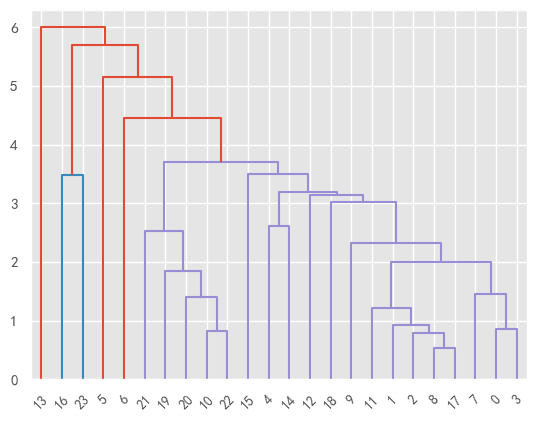

In [16]:
#dendrogram：系统树图
d1 = hierarchy.dendrogram(Z, labels = names, count_sort=False)
plt.xticks(size=10)
plt.show()

#### 对属性进行聚类

In [17]:
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
import scipy.cluster as sc
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist


In [18]:
df_list = df.values
X =np.matrix(df_list).T
# print(X)
X_std = (X - np.mean(X,axis=0))/st.tstd(X,axis=0)#注意这里要使用标准差的无偏估计
names = df.index.tolist()
print(names)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [19]:
# 计算距离
dist1 = dist.pdist(X_std,'euclidean')

In [20]:
Z = hierarchy.linkage(dist1, 'average')

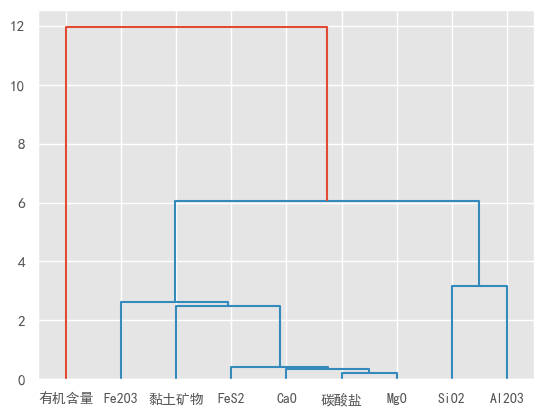

In [21]:
#dendrogram：系统树图
d1 = hierarchy.dendrogram(Z, labels = df.columns, count_sort=False)
plt.xticks(size=10)
plt.show()